In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import getpass
username = getpass.getuser()

import sys
sys.path.append('/Users/{:}/GitHub/mouse_bandit/jupyter_notebooks/helper_functions'.format(username))
import bandit_modeling as bm

sys.path.append('/Users/{:}/GitHub/mouse_bandit/data_preprocessing_code'.format(username))
sys.path.append('/Users/{:}/GitHub/mouse_bandit'.format(username))
import support_functions as sf

%matplotlib inline

In [19]:
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/markov_full.csv'.format(username), index_col=0)
#data = data[data['Condition']=='80-20']
#data.head()

### Logistic regressions:
     Left:
          -1 = left, unrewarded
           1 = left, rewarded
           0 = right (all)
           
     Right:
          -1 = right, unrewarded
           1 = right, rewarded
           0 = left (all)
           
     Full: uses merging policy -- takes whichever side has higher probability


In [20]:
X_left, X_right, y_left, y_right, c = bm.choice_history_lateral(data)

'''RIGHT'''

X_train, X_test, y_train, y_test = train_test_split(X_right, y_right, test_size=0.3, random_state=1)

lr1 = LogisticRegression()
lr1.fit(X_train, y_train)
    
lr1_proba_R = lr1.predict_proba(X_test)
lr1_predict_R = lr1.predict(X_test)

score_lr1_R = lr1.score(X_test, y_test)
metrics_lr1_R = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_R)


'''LEFT'''
X_train, X_test, y_train, y_test = train_test_split(X_left, y_left, test_size=0.3, random_state=1)

lr1 = LogisticRegression()
lr1.fit(X_train, y_train)

lr1_proba_L = lr1.predict_proba(X_test)
lr1_predict_L = lr1.predict(X_test)
#lr1_predict_L = lr1_predict_L>0.2

score_lr1_L = lr1.score(X_test, y_test)
metrics_lr1_L = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_L)

'''INTEGRATED'''
# go to whichever port has a higher probability from its model
c_train, c_test = train_test_split(c, test_size=0.3, random_state=1)

lr1_proba = np.row_stack((lr1_proba_L[:,1],lr1_proba_R[:,1]))
lr1_proba_norm_L = [lr1_proba[1,i]/np.sum(lr1_proba[:,i]) for i in range(lr1_proba.shape[1])]
lr1_proba_norm_R = [lr1_proba[0,i]/np.sum(lr1_proba[:,i]) for i in range(lr1_proba.shape[1])]
lr1_proba_norm = np.row_stack((lr1_proba_norm_L, lr1_proba_norm_R))

y_predict = lr1_proba_L[:,1]>lr1_proba_R[:,1] # predict 1s for L, 0s for R
metrics_choice = sklearn.metrics.precision_recall_fscore_support(y_test, y_predict)
    
lr1_score=1-np.abs(y_predict-y_test).sum()/len(y_test)
    
prev_choice = c_test['1_Port']
s_predict = (np.abs(y_predict-prev_choice)).astype('int')
s_test = np.abs(y_test-prev_choice).astype('int')
    
metrics_lr1 = sklearn.metrics.precision_recall_fscore_support(s_test, s_predict)

In [21]:
acc_pos,acc_neg,F1=sf.score_both_and_confuse(s_predict.values, s_test.values, confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO        79775.0        11332.0
True YES        3241.0         3809.0

F1: 0.343

Accuracy on class 0: 0.88
Accuracy on class 1: 0.54



In [22]:
metrics_lr1

(array([ 0.96095933,  0.25156859]),
 array([ 0.87561878,  0.54028369]),
 array([ 0.91630629,  0.34329233]),
 array([91107,  7050]))

In [23]:
lr1_score

0.8515337673319274

In [24]:
confidence = np.abs(np.diff(lr1_proba_norm, axis=0))
threshold = 0.6

confidence_predict = []
for i in range(len(y_test)):
    if (lr1_proba_norm_R[i]<lr1_proba_norm_L[i]): # if 2 models predict R choice (0)
        if prev_choice.values[i]==0: # and previous choice was to R
            confidence_predict.append(0) # go R
        elif (prev_choice.values[i]==1) & (confidence[0,i] > threshold): #if previous choice was L but mouse is confident
            confidence_predict.append(0) # go R
        else:
            confidence_predict.append(1)
    else: # if 2 models predict L
        if prev_choice.values[i]==1:
            confidence_predict.append(1)
        elif (prev_choice.values[i]==0) & (confidence[0,i]>threshold): # if predicts switch but not confident, stay
            confidence_predict.append(1)
        else:
            confidence_predict.append(0) # otherwise go L
            
confidence_switch = (np.abs(confidence_predict-prev_choice.values)).astype('int')

In [25]:
sklearn.metrics.precision_recall_fscore_support(s_test, confidence_switch)

(array([ 0.94682739,  0.34266287]),
 array([ 0.95437233,  0.30737589]),
 array([ 0.95058489,  0.32406161]),
 array([91107,  7050]))

In [26]:
acc_pos,acc_neg,F1=sf.score_both_and_confuse(confidence_switch, s_test.values, confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO        86950.0         4157.0
True YES        4883.0         2167.0

F1: 0.324

Accuracy on class 0: 0.95
Accuracy on class 1: 0.31



/Users/celiaberon/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


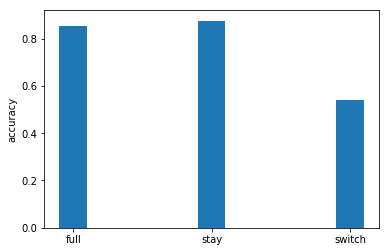

In [27]:
height_a = [lr1_score, metrics_lr1[1][0], metrics_lr1[1][1]]

barWidth = 0.2
# The x position of bars
r1 = np.arange(len(height_a))

plt.bar(r1, height_a, width=barWidth)

conditions=['full','stay','switch']
plt.xticks(range(len(height_a)), conditions)
plt.ylabel('accuracy')
plt.legend()

### take a look at probabilities from each model to switch right or left to compare predictions

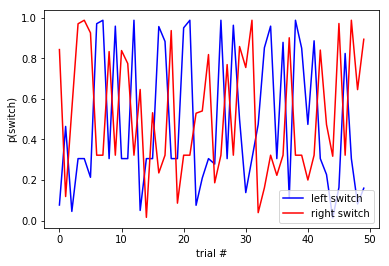

In [28]:
plt.plot(lr1_proba_L[0:50,1], 'b', label='left switch')
plt.plot(lr1_proba_R[0:50,1], 'r', label='right switch')

plt.xlabel('trial #')
plt.ylabel('p(switch)')
plt.legend()

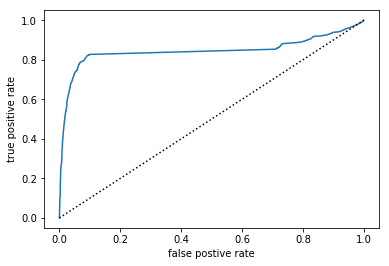

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, lr1_proba[0])
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], ':k')
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')

In [30]:
metrics_lr1

(array([ 0.96095933,  0.25156859]),
 array([ 0.87561878,  0.54028369]),
 array([ 0.91630629,  0.34329233]),
 array([91107,  7050]))

### null model (single logistic regression) to compare against)

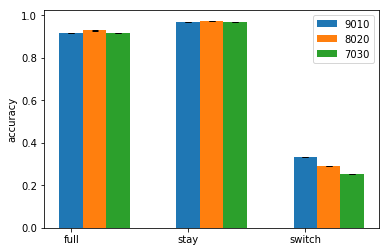

In [31]:
bm.logreg_sim_plot(data) # null model (trained on both ports together) on each condition

### tuning the bias of the mouse to left or right port - not worth pursuing

In [32]:
for i in np.arange(0,1.1,0.1):
    print('decision boundary at', i)
    test_predict = lr1_proba[0]>i
    acc_pos,acc_neg,F1=sf.score_both_and_confuse(test_predict, y_test.values, confusion=False,disp=True)
    

decision boundary at 0.0
          Predicted NO  Predicted YES
True NO            0.0        49564.0
True YES           0.0        48593.0

F1: 0.662

Accuracy on class 0: 0.00
Accuracy on class 1: 1.00

decision boundary at 0.1
          Predicted NO  Predicted YES
True NO         3701.0        45863.0
True YES        2665.0        45928.0

F1: 0.654

Accuracy on class 0: 0.07
Accuracy on class 1: 0.95

decision boundary at 0.2
          Predicted NO  Predicted YES
True NO         9576.0        39988.0
True YES        5087.0        43506.0

F1: 0.659

Accuracy on class 0: 0.19
Accuracy on class 1: 0.90

decision boundary at 0.3
          Predicted NO  Predicted YES
True NO        14125.0        35439.0
True YES        6909.0        41684.0

F1: 0.663

Accuracy on class 0: 0.28
Accuracy on class 1: 0.86

decision boundary at 0.4
          Predicted NO  Predicted YES
True NO        45825.0         3739.0
True YES       10084.0        38509.0

F1: 0.848

Accuracy on class 0: 0.92
Accurac

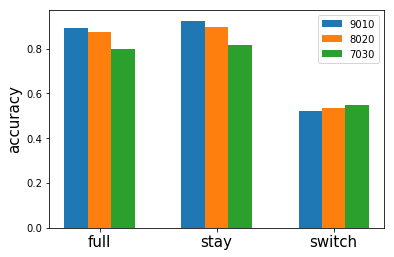

In [33]:
conditions = ['90-10', '80-20', '70-30']

lr1_score=[]
metrics_lr1 = np.zeros((4,2))

for condition in conditions:
    d=data.copy()
    d=d[data['Condition']==condition]
    
    X_left, X_right, y_left, y_right, c = bm.choice_history_lateral(d)

    '''RIGHT'''

    X_train, X_test, y_train, y_test = train_test_split(X_right, y_right, test_size=0.3, random_state=1)

    lr1 = LogisticRegression(C=1)
    lr1.fit(X_train, y_train)

    lr1_proba_R = lr1.predict_proba(X_test)
    lr1_predict_R = lr1.predict(X_test)
    #lr1_predict_R = lr1_predict_R>0.2

    score_lr1_R = lr1.score(X_test, y_test)
    metrics_lr1_R = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_R)
    
    
    '''LEFT'''
    X_train, X_test, y_train, y_test = train_test_split(X_left, y_left, test_size=0.3, random_state=1)

    lr1 = LogisticRegression()
    lr1.fit(X_train, y_train)

    lr1_proba_L = lr1.predict_proba(X_test)
    lr1_predict_L = lr1.predict(X_test)
    #lr1_predict_L = lr1_predict_L>0.2

    score_lr1_L = lr1.score(X_test, y_test)
    metrics_lr1_L = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_L)


    '''INTEGRATED'''
    # go to whichever port has a higher probability from its model
    c_train, c_test = train_test_split(c, test_size=0.3, random_state=1)

    lr1_proba = [lr1_proba_L[:,1], lr1_proba_R[:,1]]
    y_predict = lr1_proba_L[:,1]>lr1_proba_R[:,1]
    metrics = sklearn.metrics.precision_recall_fscore_support(y_test, y_predict)
    
    lr1_score.append(1-np.abs(y_predict-y_test).sum()/len(y_test))
    
    prev_choice = c_test['1_Port']
    s_predict = (np.abs(y_predict-prev_choice)).astype('int')
    s_test = np.abs(y_test-prev_choice).astype('int')
    
    metrics_temp = sklearn.metrics.precision_recall_fscore_support(s_test, s_predict)
    metrics_lr1 = np.dstack((metrics_lr1, np.array(metrics_temp)))

metrics_lr1 = metrics_lr1[:,:,1:len(conditions)+1]

'''plot results'''

height_a = [lr1_score[0], metrics_lr1[1,0,0], metrics_lr1[1,1,0]]
height_b = [lr1_score[1], metrics_lr1[1,0,1], metrics_lr1[1,1,1]]
height_c = [lr1_score[2], metrics_lr1[1,0,2], metrics_lr1[1,1,2]]

barWidth = 0.2
# The x position of bars
r1 = np.arange(len(height_a))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

prob_labels = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='9010')
plt.bar(r2, height_b, width=barWidth, label='8020')
plt.bar(r3, height_c, width=barWidth, label='7030')

plt.xticks(r2, prob_labels, size=15)
plt.ylabel('accuracy', size=15)
plt.legend()

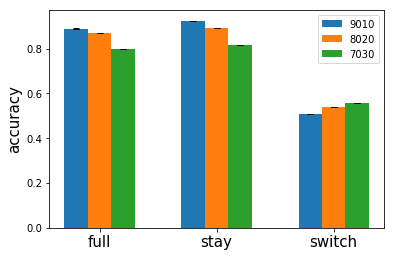

In [58]:
n_sims=100
seed1 = np.random.randint(100000,size=n_sims)

conditions = ['90-10', '80-20', '70-30']

lr1_score=[]
metrics_lr1 = np.zeros((4,2))
acc_switch=[]
acc_stay=[]

for condition in conditions:
    #acc_switch.append(np.mean(metrics_lr1[1,1,0]))
    d=data.copy()
    d=d[data['Condition']==condition]
    
    X_left, X_right, y_left, y_right, c = bm.choice_history_lateral(d)
    
    for n in range(1,n_sims):

        '''RIGHT'''

        X_train, X_test, y_train, y_test = train_test_split(X_right, y_right, test_size=0.3, random_state=seed1[n])

        lr1 = LogisticRegression(C=1)
        lr1.fit(X_train, y_train)

        lr1_proba_R = lr1.predict_proba(X_test)
        lr1_predict_R = lr1.predict(X_test)
        #lr1_predict_R = lr1_predict_R>0.2

        score_lr1_R = lr1.score(X_test, y_test)
        metrics_lr1_R = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_R)

    
        '''LEFT'''
        X_train, X_test, y_train, y_test = train_test_split(X_left, y_left, test_size=0.3, random_state=seed1[n])

        lr1 = LogisticRegression()
        lr1.fit(X_train, y_train)

        lr1_proba_L = lr1.predict_proba(X_test)
        lr1_predict_L = lr1.predict(X_test)
        #lr1_predict_L = lr1_predict_L>0.2

        score_lr1_L = lr1.score(X_test, y_test)
        metrics_lr1_L = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_L)


        '''INTEGRATED'''
        # go to whichever port has a higher probability from its model
        c_train, c_test = train_test_split(c, test_size=0.3, random_state=seed1[n])

        lr1_proba = [lr1_proba_L[:,1], lr1_proba_R[:,1]]
        y_predict = lr1_proba_L[:,1]>lr1_proba_R[:,1]
        metrics = sklearn.metrics.precision_recall_fscore_support(y_test, y_predict)

        lr1_score.append(1-np.abs(y_predict-y_test).sum()/len(y_test))

        prev_choice = c_test['1_Port']
        s_predict = (np.abs(y_predict-prev_choice)).astype('int')
        s_test = np.abs(y_test-prev_choice).astype('int')

        metrics_temp = sklearn.metrics.precision_recall_fscore_support(s_test, s_predict)
        metrics_lr1 = np.dstack((metrics_lr1, np.array(metrics_temp)))
        acc_switch.append(metrics_temp[1][1])
        acc_stay.append(metrics_temp[1][0])

metrics_lr1 = metrics_lr1[:,:,1:len(conditions)+1]

'''plot results'''

height_a = [np.mean(lr1_score[0:(n_sims-1)]), np.mean(acc_stay[0:(n_sims-1)]), np.mean(acc_switch[0:(n_sims-1)])]
height_b = [np.mean(lr1_score[n_sims-1:2*(n_sims-1)]), np.mean(acc_stay[(n_sims-1):2*(n_sims-1)]), np.mean(acc_switch[(n_sims-1):2*(n_sims-1)])]
height_c = [np.mean(lr1_score[2*(n_sims-1):]), np.mean(acc_stay[2*(n_sims-1):]), np.mean(acc_switch[2*(n_sims-1):])]

ystd1 = [np.std(lr1_score[0:(n_sims-1)]), np.std(acc_stay[0:(n_sims-1)]), np.std(acc_switch[0:(n_sims-1)])]
yerr1 = [ystd1[i] / np.sqrt(n_sims) for i in range(len(ystd1))]

ystd2 = [np.std(lr1_score[n_sims-1:2*(n_sims-1)]), np.std(acc_stay[(n_sims-1):2*(n_sims-1)]), np.std(acc_switch[(n_sims-1):2*(n_sims-1)])]
yerr2 = [ystd2[i] / np.sqrt(n_sims) for i in range(len(ystd2))]

ystd3 = [np.std(lr1_score[2*(n_sims-1):]), np.std(acc_stay[2*(n_sims-1):]), np.std(acc_switch[2*(n_sims-1):])]
yerr3 = [ystd3[i] / np.sqrt(n_sims) for i in range(len(ystd3))]

barWidth = 0.2
# The x position of bars
r1 = np.arange(len(height_a))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

prob_labels = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, yerr=yerr1, capsize=3, label='9010')
plt.bar(r2, height_b, width=barWidth, yerr=yerr2, capsize=3, label='8020')
plt.bar(r3, height_c, width=barWidth, yerr=yerr3, capsize=3, label='7030')

plt.xticks(r2, prob_labels, size=15)
plt.ylabel('accuracy', size=15)
plt.legend()


In [51]:
acc_stay[(n_sims-1):2*(n_sims-1)]

[0.89465368244550492,
 0.89624254152556038,
 0.89560032232070907,
 0.89311821724149032,
 0.89223817976440212,
 0.89287094281298296,
 0.89260296911731551,
 0.89292043953211098,
 0.89141788638854857]

### Shuffled

In [70]:
X_test.shape

(31920, 10)

In [107]:
seed1 = np.random.randint(100000,size=n_sims)

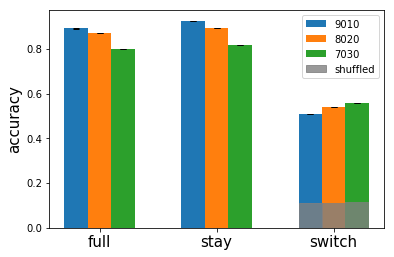

In [108]:
n_sims=100
#seed1 = np.random.randint(100000,size=n_sims)

conditions = ['90-10', '80-20', '70-30']

lr1_score=[]
metrics_lr1 = np.zeros((4,2))
metrics_lr1_shuffled = np.zeros((4,2))
acc_switch=[]
acc_stay=[]

for condition in conditions:
    #acc_switch.append(np.mean(metrics_lr1[1,1,0]))
    d=data.copy()
    d=d[data['Condition']==condition]
    
    X_left, X_right, y_left, y_right, c = bm.choice_history_lateral(d)
    
    for n in range(1,n_sims):

        '''RIGHT'''

        X_train, X_test, y_train, y_test = train_test_split(X_right, y_right, test_size=0.3, random_state=seed1[n])

        lr1 = LogisticRegression(C=1)
        lr1.fit(X_train, y_train)

        lr1_proba_R = lr1.predict_proba(X_test)
        lr1_predict_R = lr1.predict(X_test)
        #lr1_predict_R = lr1_predict_R>0.2

        score_lr1_R = lr1.score(X_test, y_test)
        metrics_lr1_R = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_R)

    
        '''LEFT'''
        X_train, X_test, y_train, y_test = train_test_split(X_left, y_left, test_size=0.3, random_state=seed1[n])

        lr1 = LogisticRegression()
        lr1.fit(X_train, y_train)

        lr1_proba_L = lr1.predict_proba(X_test)
        lr1_predict_L = lr1.predict(X_test)
        #lr1_predict_L = lr1_predict_L>0.2

        score_lr1_L = lr1.score(X_test, y_test)
        metrics_lr1_L = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_L)


        '''INTEGRATED'''
        # go to whichever port has a higher probability from its model
        c_train, c_test = train_test_split(c, test_size=0.3, random_state=seed1[n])

        lr1_proba = [lr1_proba_L[:,1], lr1_proba_R[:,1]]
        y_predict = lr1_proba_L[:,1]>lr1_proba_R[:,1]
        metrics = sklearn.metrics.precision_recall_fscore_support(y_test, y_predict)

        lr1_score.append(1-np.abs(y_predict-y_test).sum()/len(y_test))

        prev_choice = c_test['1_Port']
        s_predict = (np.abs(y_predict-prev_choice)).astype('int')
        s_test = np.abs(y_test-prev_choice).astype('int')
        
        metrics_temp = sklearn.metrics.precision_recall_fscore_support(s_test, s_predict)
        metrics_lr1 = np.dstack((metrics_lr1, np.array(metrics_temp)))
        np.random.shuffle(s_test.values)
        metrics_temp_shuffled = sklearn.metrics.precision_recall_fscore_support(s_test, s_predict)
        metrics_lr1_shuffled = np.dstack((metrics_lr1_shuffled, np.array(metrics_temp_shuffled)))
        acc_switch.append(metrics_temp[1][1])
        acc_stay.append(metrics_temp[1][0])

metrics_lr1 = metrics_lr1[:,:,1:len(conditions)+1]
metrics_lr1_shuffled = metrics_lr1_shuffled[:,:,1:len(conditions)+1]


'''plot results'''

height_a = [np.mean(lr1_score[0:(n_sims-1)]), np.mean(acc_stay[0:(n_sims-1)]), np.mean(acc_switch[0:(n_sims-1)])]
height_b = [np.mean(lr1_score[n_sims-1:2*(n_sims-1)]), np.mean(acc_stay[(n_sims-1):2*(n_sims-1)]), np.mean(acc_switch[(n_sims-1):2*(n_sims-1)])]
height_c = [np.mean(lr1_score[2*(n_sims-1):]), np.mean(acc_stay[2*(n_sims-1):]), np.mean(acc_switch[2*(n_sims-1):])]

ystd1 = [np.std(lr1_score[0:(n_sims-1)]), np.std(acc_stay[0:(n_sims-1)]), np.std(acc_switch[0:(n_sims-1)])]
yerr1 = [ystd1[i] / np.sqrt(n_sims) for i in range(len(ystd1))]

ystd2 = [np.std(lr1_score[n_sims-1:2*(n_sims-1)]), np.std(acc_stay[(n_sims-1):2*(n_sims-1)]), np.std(acc_switch[(n_sims-1):2*(n_sims-1)])]
yerr2 = [ystd2[i] / np.sqrt(n_sims) for i in range(len(ystd2))]

ystd3 = [np.std(lr1_score[2*(n_sims-1):]), np.std(acc_stay[2*(n_sims-1):]), np.std(acc_switch[2*(n_sims-1):])]
yerr3 = [ystd3[i] / np.sqrt(n_sims) for i in range(len(ystd3))]

height_a_shuffled = np.mean(metrics_lr1_shuffled[1,1,0])
height_b_shuffled = np.mean(metrics_lr1_shuffled[1,1,1])
height_c_shuffled = np.mean(metrics_lr1_shuffled[1,1,2])

yerr1_shuffled = np.std(acc_switch[0:(n_sims-1)]) / np.sqrt(n_sims)

yerr2_shuffled = np.std(acc_switch[(n_sims-1):2*(n_sims-1)]) / np.sqrt(n_sims)

yerr3_shuffled = np.std(acc_switch[2*(n_sims-1):]) / np.sqrt(n_sims)

barWidth = 0.2
# The x position of bars
r1 = np.arange(len(height_a))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

prob_labels = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, yerr=yerr1, capsize=3, label='90-10')
plt.bar(r2, height_b, width=barWidth, yerr=yerr2, capsize=3, label='80-20')
plt.bar(r3, height_c, width=barWidth, yerr=yerr3, capsize=3, label='70-30')
plt.bar(r1[2], height_a_shuffled, width=barWidth, label='shuffled', color='gray', alpha=0.8, edgeColor='gray')
plt.bar(r2[2], height_b_shuffled, width=barWidth, color='gray', alpha=0.8)
plt.bar(r3[2], height_c_shuffled, width=barWidth, color='gray', alpha=0.8)


plt.xticks(r2, prob_labels, size=15)
plt.ylabel('accuracy', size=15)
plt.legend()



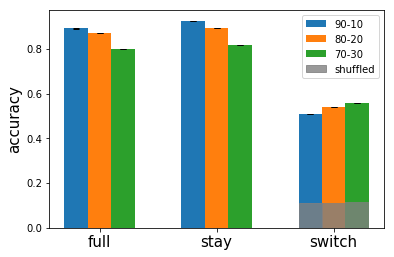

In [111]:
prob_labels = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, yerr=yerr1, capsize=3, label='90-10')
plt.bar(r2, height_b, width=barWidth, yerr=yerr2, capsize=3, label='80-20')
plt.bar(r3, height_c, width=barWidth, yerr=yerr3, capsize=3, label='70-30')
plt.bar(r1[2], height_a_shuffled, width=barWidth, label='shuffled', color='gray', alpha=0.8, edgeColor='gray')
plt.bar(r2[2], height_b_shuffled, width=barWidth, color='gray', alpha=0.8)
plt.bar(r3[2], height_c_shuffled, width=barWidth, color='gray', alpha=0.8)


plt.xticks(r2, prob_labels, size=15)
plt.ylabel('accuracy', size=15)
plt.legend()




In [94]:
metrics_lr1_shuffled[1,1,0]

0.10041060097051138

In [77]:
np.random.shuffle(s_test.values)